In [262]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import LabelEncoder



In [263]:
def load_dataset(filepath):
    df= pd.read_csv(filepath)
    
    return df

In [264]:

def preprocess(df):
    df = df.dropna()

    
    return df

    



In [265]:
def correlation(dataframe, threshold=0.8):
    """
    This function identifies highly correlated factors in a given DataFrame.
    
    Parameters:
    dataframe (pd.DataFrame): The input DataFrame containing the factors.
    threshold (float): The correlation threshold above which factors are considered highly correlated.
    
    Returns:
    list: A list of tuples containing pairs of highly correlated factors.
    """
    correlated_pairs = []
    correlation_matrix = dataframe.corr()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))
    
    return correlated_pairs

In [266]:


def train_random_forest_classifier(dataframe, target_column):
    # Prepare features and target
    X = dataframe.drop(target_column, axis=1)
    y = dataframe[target_column]

    # Print original class distribution
    print("\nOriginal class distribution:")
    print(y.value_counts(normalize=True))

    # Split the data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )

    # Apply SMOTE to balance the training data
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Print balanced class distribution
    print("\nBalanced training set class distribution:")
    print(pd.Series(y_train_balanced).value_counts(normalize=True))

    # Initialize the model (no need for class_weight since data is balanced)
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    )

    # Train the model on balanced data
    model.fit(X_train_balanced, y_train_balanced)

    # Print feature importances
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))

    return model, X_test, y_test

In [267]:

def evaluate_model(model, X_test, y_test):
    """
    Evaluates model performance using ROC analysis and finds optimal threshold.
    
    Parameters:
    model: Trained classifier with predict_proba method
    X_test: Test features
    y_test: True test labels
    
    Returns:
    dict: Performance metrics and optimal threshold
    """
    # Get positive class probabilities
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Find optimal threshold using Youden's J statistic (TPR - FPR)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label=f'Optimal threshold = {optimal_threshold:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Evaluate with optimal threshold
    y_pred = (y_pred_prob >= optimal_threshold).astype(int)
    
    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print results
    print(f"Optimal Threshold: {optimal_threshold:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC-ROC: {roc_auc:.3f}")
    
    print("\nConfusion Matrix:")
    print(f"TN: {conf_matrix[0][0]}  FP: {conf_matrix[0][1]}")
    print(f"FN: {conf_matrix[1][0]}  TP: {conf_matrix[1][1]}")

    


Original class distribution:
failed
0    0.771683
1    0.228317
Name: proportion, dtype: float64

Balanced training set class distribution:
failed
0    0.5
1    0.5
Name: proportion, dtype: float64

Top 10 most important features:
             feature  importance
1  page_cache_memory    0.145939
5   avg_memory_usage    0.119684
6      max_cpu_usage    0.118351
7   max_memory_usage    0.112848
0    assigned_memory    0.103089
3   vertical_scaling    0.101113
4      avg_cpu_usage    0.100391
8     requested_cpus    0.074342
2           duration    0.064055
9   requested_memory    0.060187


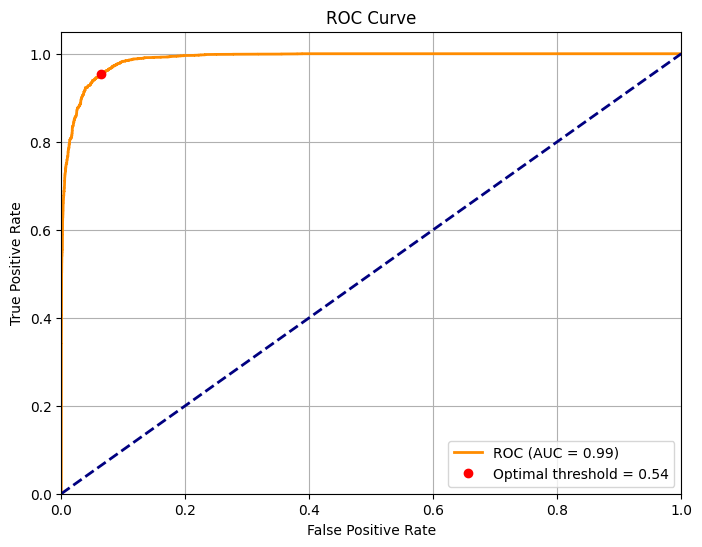

Optimal Threshold: 0.545
Accuracy: 0.940
Precision: 0.815
Recall: 0.954
F1 Score: 0.879
AUC-ROC: 0.989

Confusion Matrix:
TN: 57706  FP: 3938
FN: 837  TP: 17401
Model Evaluation Results:


In [269]:

def main():
    """
    This function is the main entry point for the Random Forest Classifier application.
    
    It performs the following steps:
    
    """
    df =load_dataset("final_resource.csv")
    df=df.drop(['cpu_usage_distribution', 'tail_cpu_usage_distribution','event'], axis=1)

    

    # Preprocess the data
    df = preprocess(df)

    
    model,X_test,y_test= train_random_forest_classifier(df, "failed")

    results = evaluate_model(model, X_test, y_test)     
    
    joblib.dump(model, "resource_rf.pkl")
    # Print results
    print("Model Evaluation Results:")
    
    

if __name__ == "__main__":
    main()  
    
